In [150]:
import json
import os
import subprocess

import numpy as np
from pathlib import Path
import yaml
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd

from matplotlib.ticker import MaxNLocator
import lossmaps as lm
import xobjects as xo

import xtrack as xt
import xcoll as xc

import lossmaps as lm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import xarray as xr

import json

import xtrack as xt
import xpart as xp
import xobjects as xo


import pickle 
import h5py
import io
import scipy

# Particles

In [160]:
class ParticleAnalysis():

    def __init__(self, element_type, n_sigma, length, xdim, ydim, jaw_L, bend=None, align_angle = None, line_idx= None, 
                 beam = 2, plane = 'V',
                 pot_crit = 21.34, #16 #eV Silicon
                 en_crit = 5.7e9 / 1e-2 #eV/m Silicon    #dp_Si = 1.92e-10 #m
                 ):

        self.beam = beam
        self.plane = plane
        self.element_type = element_type
        self.n_sigma = n_sigma
        self.length = length
        self.xdim = xdim
        self.ydim = ydim
        self.align_angle = align_angle
        self.jaw_L = jaw_L
        self.en_crit = en_crit
        self.pot_crit = pot_crit
        self.line_idx = line_idx
        self.p0c = None
        self.npart = None
        self.data = None
        self.impact_part = None
        self.line_idx = line_idx
        self.abs_y_low = self.jaw_L
        self.abs_y_up = self.jaw_L + self.ydim
        self.abs_x_low = -self.xdim/2
        self.abs_x_up = self.xdim/2

        self.n_jobs = None
        self.part_per_job = None
        
        self.lossmap = None 
        self.losses = None
        self.TCCS_name = 'tccs.5r3.b2'
        self.TCCP_name = 'tccp.4l3.b2'
        self.TARGET_name = 'target.4l3.b2'
        self.TCLA_name = 'tcla.a5l3.b2'
        
        if element_type == 'crystal':
            self.bend = bend 
            
            
    def retreive_file_path(self, prefix_name, file_name = 'particle*.h5', path = "/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/"):

        test_list = [path + i for i in os.listdir(path) if prefix_name in i]
        for test_name in test_list:

            n_jobs = int(subprocess.check_output("find "+ test_name +" -maxdepth 1 -mindepth 1 -type d | grep Job. | wc -l", shell=True))

            path_list =[]

            for i in range(n_jobs):
                file_path_part = (subprocess.check_output("echo " + test_name + '/Job.' + str(i) + '/Outputdata/' + file_name, shell=True)).decode('ascii').strip()
                if os.path.exists(file_path_part):
                    path_list.append(file_path_part)

            n_jobs_verify  = len(path_list)
            if n_jobs != n_jobs_verify:
                print("!!! Succesful Jobs: ", n_jobs_verify, '/', n_jobs, ' in file: ', test_name)
        return path_list   
    
    

    def load_particles(self, path, df_key = 'particles', Condor=True, file_name='particle*.h5', part_per_job = 100000):
        
        if Condor == True:
            self.part_per_job = part_per_job
            h5_file_path = self.retreive_file_path(prefix_name = path, file_name = file_name)
            self.n_jobs = len(h5_file_path)
        else:
            default_path = "/eos/home-c/cmaccani/xsuite_sim/two_cryst_sim/Condor/"
            h5_file_path = default_path + path

        if not hasattr(h5_file_path, '__iter__') or isinstance(h5_file_path, str):
            h5_file_path = [h5_file_path]

        df_particles = pd.DataFrame()
        npart = 0
        i =0 
        for file in h5_file_path:
            try:
                print( i , "   npart: ", npart)
                df_tmp = pd.read_hdf(file, key=df_key) #test_particles_B2V
                df_tmp['particle_id'] = df_tmp['particle_id'] + self.part_per_job*i    
                df_tmp['parent_particle_id'] = df_tmp['parent_particle_id'] + self.part_per_job*i
                df_particles = pd.concat([df_particles, df_tmp])
            except FileNotFoundError:
                print(f"Error: File not found at {file}")
                continue
            except pd.errors.EmptyDataError:
                print(f"Error: The HDF5 file at {file} is empty.")
                continue
            except Exception as e:
                print(f"Error: An unexpected error occurred - {e}")
                continue
            npart = npart + len(df_tmp)
            i = i + 1
            
        #check if there are duplicated         
        if self.element_type == 'target':        
            data = df_particles['particle_id']
            duplicated_mask = data.duplicated()
            if len(data[duplicated_mask]) != 0:
                print(f'There are repeated particle ids: {data[duplicated_mask]}')
            
        self.npart = npart       
        self.data = df_particles
            
        p0c = None
        if len(self.data['p0c'].unique()) == 1:
            p0c = self.data['p0c'].unique()[0]
        else:
            print('There are particles at different energies')            
        self.p0c = p0c
        
        if self.element_type == 'crystal':
            xp_crit0 = np.sqrt(2.0*self.pot_crit/self.p0c)
            Rcrit = self.p0c/self.en_crit
            self.xp_crit = xp_crit0*(1-Rcrit/self.bend)
            if(self.xp_crit < 0):
                print("!!!!!!!!!!!!! \nERROR: particles at",self.p0c, f"eV cannot be channeled if bending is {self.bend} m \n!!!!!!!!!!!!!")

        
    def plot_distributions(self, x, y, px, py, **kwargs):
        
        hitting_particles = len(x[(x >= self.abs_x_low) & (x <= self.abs_x_up) & (y >= self.abs_y_low) & (y <= self.abs_y_up)])

        fig1 = plt.figure(figsize=(22, 10))
        ax1 = fig1.add_subplot(2,3,1)
        ax1.hist(x, bins=100)
        ax1.set_xlabel('x [mm]')
        ax1.set_ylabel("")
        ax1.axvline(self.abs_x_low, color = 'r', linestyle = '--')
        ax1.axvline(self.abs_x_up, color = 'r', linestyle = '--')
        ax1.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.xticks()[0]])

        ax2 = fig1.add_subplot(2,3,2)
        ax2.hist(y, bins=100) 
        ax2.set_xlabel('y [mm]')
        ax2.axvline(self.abs_y_low, color = 'r', linestyle = '--')
        ax2.axvline(self.abs_y_up, color = 'r', linestyle = '--')
        ax2.set_ylabel('')
        
        ax2.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.xticks()[0]])
        ax2.set_title(f'Total particles: {len(x)},      Hitting particles: {hitting_particles}')

        ax3 = fig1.add_subplot(2,3,3)
        h = ax3.hist2d(x, y, bins=100, norm=matplotlib.colors.LogNorm())#,  vmin = 1, vmax = 1e6, range = ([-40e-6, 40e-6], [-40e-6,40e-6])) 
        ax3.set_xlabel(r'x [mm]')
        #ax3.set_ylim(0,0.008)
        ax3.set_ylabel(r'y [mm]')
        ax3.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.xticks()[0]])
        ax3.set_yticks(ticks=plt.yticks()[0], labels=[f"{x_tick*1e3:.{2}f}" for x_tick in plt.yticks()[0]])
        ax3_tw = ax3.twinx()
        sigma_abs = self.jaw_L/self.n_sigma
        ax3_tw.set_ylim(ax3.get_ylim()[0]/sigma_abs, ax3.get_ylim()[1]/sigma_abs)
        
        if ax3_tw.get_ylim()[1] - ax3_tw.get_ylim()[0] < 20:
            n_ticks = 2
        elif ax3_tw.get_ylim()[1] - ax3_tw.get_ylim()[0] > 20 and ax3_tw.get_ylim()[0] - ax3_tw.get_ylim()[1] < 60:
            n_ticks = 4
        elif ax3_tw.get_ylim()[1] - ax3_tw.get_ylim()[0] > 60 and ax3_tw.get_ylim()[1] - ax3_tw.get_ylim()[0] < 100:
            n_ticks = 8
        elif ax3_tw.get_ylim()[1] - ax3_tw.get_ylim()[0] > 100:
            n_ticks = 16
        yticks = np.arange(np.ceil(ax3_tw.get_ylim()[0]), np.floor(ax3_tw.get_ylim()[1]) + 1, n_ticks)
        ax3_tw.set_yticks(yticks)
        ax3_tw.set_ylabel(r' n $\sigma$')
        rect = patches.Rectangle((self.abs_x_low, self.abs_y_low), self.abs_x_up - self.abs_x_low, self.abs_y_up - self.abs_y_low, linewidth=1, edgecolor='r', facecolor='none')
        ax3.add_patch(rect)
        
        if "sigma" in kwargs and kwargs['sigma'] == True:
            ax3_tw.axhline(self.n_sigma, color = 'r', linestyle = '--')
            #ax3_tw.text( 0,0, r'TCP $\sigma$') #max(ax3.get_xticks())-1.5e-3, 4,

        axins = inset_axes(ax3, height="100%",  width="5%", loc='right', borderpad=-6 )
        fig1.colorbar(h[3], cax=axins, orientation='vertical', label='Count (log scale)')
        ax3.grid(linestyle=':')

        ax12 = fig1.add_subplot(2,3,4)
        ax12.hist(px, bins=100)
        ax12.set_xlabel(r'px [$\mu$rad]')
        ax12.set_ylabel("")
        
        ax12.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e6:.{1}f}" for x_tick in plt.xticks()[0]])


        ax22 = fig1.add_subplot(2,3,5)
        ax22.hist(py, bins=100) 
        ax22.set_xlabel(r'py [$\mu$rad]')
        ax22.set_ylabel('')
        ax22.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e6:.{1}f}" for x_tick in plt.xticks()[0]])
        if self.element_type == 'crystal' and "xpcrit" in kwargs and kwargs['xpcrit'] == True:   
            mean_angle = None
            if self.align_angle is None and "py_mean" in kwargs:
                mean_angle = kwargs['py_mean']
            elif self.align_angle is not None:
                mean_angle = self.align_angle
            elif "calculate_mean" in kwargs and kwargs['calculate_mean'] == True:
                mean_angle = self.calculate_mean_py(**kwargs)
             
            if mean_angle is not None: 
                ax22.axvline(mean_angle, color = 'red', linestyle = '-', alpha = 0.8)
                if(self.xp_crit < 0):
                    print(f"!!!!!!!!!!!!! \nERROR: particles at {self.p0c} cannot be channeled if bending is {self.bend} \n!!!!!!!!!!!!!")
                else:
                    ax22.axvline(mean_angle  + np.abs(self.xp_crit), color = 'red', linestyle = '--', alpha = 0.9)
                    ax22.axvline(mean_angle - np.abs(self.xp_crit), color = 'red', linestyle = '--', alpha = 0.9)
                    chann_mask = (py > mean_angle  - np.abs(self.xp_crit)) & (py < mean_angle  + np.abs(self.xp_crit))
                    chann = len(py[chann_mask])
                    ax22.set_title(f'N particle inside critical angle range: {chann}')

        ax32 = fig1.add_subplot(2,3,6)
        h2 = ax32.hist2d(px, py, bins=100, norm=matplotlib.colors.LogNorm())  #,, norm=matplotlib.colors.LogNorm() range = ([-40e-6, 40e-6], [-40e-6,40e-6])
        ax32.set_xlabel(r'px [$\mu$rad]')
        ax32.set_ylabel(r'py [$\mu$rad]')
        ax32.set_xticks(ticks=plt.xticks()[0], labels=[f"{x_tick*1e6:.{1}f}" for x_tick in plt.xticks()[0]])
        ax32.set_yticks(ticks=plt.yticks()[0], labels=[f"{x_tick*1e6:.{1}f}" for x_tick in plt.yticks()[0]])
        axins_2 = inset_axes(ax32, height="100%",  width="5%", loc='right', borderpad=-6 )
        fig1.colorbar(h2[3], cax=axins_2, orientation='vertical', label='Count (log scale)')
        ax32.grid(linestyle=':')

        if "log" in kwargs and kwargs['log'] == True:  
            ax22.set_yscale("log")
            ax2.set_yscale("log")
            ax12.set_yscale("log")
            ax1.set_yscale("log")

        #fig1.suptitle('plot')
        plt.show()
        #return fig1, [ax1,ax2,ax3]
        
        
    def compute_impact_particles(self, sigma = False, log=False, xpcrit= False, Monitor=True, **kwargs):
        if self.data is None:
            self.load_particles(kwargs['h5_file_path'])
            
        if not Monitor:
            impact_part = self.data[(self.data.at_element == self.line_idx) & (self.data.state<0)]
            self.impact_part = impact_part
            #print("Impacting particles: ", len(self.impact_part), "/", self.npart)
        elif Monitor:
            impact_part = self.data
        self.plot_distributions(impact_part['x'], impact_part['y'], impact_part['px'], impact_part['py'], sigma=sigma, log=log, xpcrit=xpcrit)

    def compute_channeled_part(self, idx, total=None):
        df_chann = self.data[(self.data['this_turn']==self.data['at_turn']) & (self.data['at_element']==idx) &  (self.data['py'] > self.align_angle - np.abs(self.xp_crit)) & (self.data['py'] < self.align_angle  + np.abs(self.xp_crit))]
        chann_num = len(df_chann)
        print('Number of channeled particles over hits on crystal: ', chann_num, '/', self.npart)
        if total is not None:
            print(f'over a total number of particles in simulation of {total}')
        
    
    def load_lossmap(self, path, Condor = True, file_name='lossmap*', plot = True, layout = "./input_files/layout_flat_top_b2.tfs", zoom = True, outfile = None):     
        if Condor == True:
            path = self.retreive_file_path(path, file_name=file_name)     
        self.lossmap = lm.SimulatedLossMap(lmtype=lm.LMType[f'B{self.beam}{self.plane}'], machine=lm.Machine.LHC)
        self.lossmap.load_data_json(json_files=path)
        self.losses = self.lossmap._losses
        if plot:    
            lm.plot_lossmap(self.lossmap, zoom = zoom, layout = layout,  outfile = outfile)
            
    def compute_losses(self, path=None):
        if self.lossmap is None:
            self.load_lossmap(path)
        df = self.lossmap._losses
        colls_length_dict = {self.TCLA_name: 1.0, self.TCCS_name: 0.004, self.TCCP_name: 0.07, self.TARGET_name: 0.005,  'tcp.d6r7.b2': 0.6}
        losses_df = df[df['name'].isin(colls_length_dict.keys())].copy()
        losses_df.loc[:, 'length'] = losses_df['name'].map(colls_length_dict)
        losses_df.loc[:, 'npart']  = losses_df['losses'] * losses_df['length']
        return losses_df

In [154]:
! ls -th ${HOME_TWOCRYST}/Condor

TEST_IR7_IR3_rem_TCCS_7.2__target_absorber_20240219-1112
TEST_IR7rem_TCCS_8.7__target_absorber_20240112-1529
TEST_IR7rem_TCCS_8.7__target_absorber_20240112-1525
TEST_IR7rem_TCCS_8.7__target_absorber_20240112-1524
TEST_IR7rem_TCCS_8.7__target_absorber_20240112-1058
TEST_IR7rem_TCCS_8.7__target_absorber_20240111-1956
TEST_IR7rem_TCCS_8.2__target_absorber_20240111-1953
TEST_IR7rem_TCCS_7.7__target_absorber_20240111-1951
TEST_IR7rem_TCCS_7.2__target_absorber_20240111-1949
TEST_IR7rem_TCCS_7.7__target_absorber_20240111-1947
TEST_IR3_IR7rem_TCCS_8.7__target_absorber_20240111-1944
TEST_IR3_IR7rem_TCCS_8.2__target_absorber_20240111-1942
TEST_IR3_IR7rem_TCCS_7.7__target_absorber_20240111-1941
TEST_IR3_IR7rem_TCCS_7.2__target_absorber_20240111-1939
TEST_IR3_IR7rem_TCCS_7.2__target_absorber_20240111-1227
TEST_IR7rem_TCCS_7.2__target_absorber_20240110-1849
TEST_IR3_IR7rem_TCCS_7.2__target_absorber_20240110-1845
TEST_IR3_IR7rem_TCCS_7.2__target_absorber_20240110-1254
TEST_IR3_IR7rem_TCCS_7.2__targe

In [45]:
IR7rem_TCCS_7_2 = "TEST_IR7rem_TCCS_7.2__target_absorber_20240110-1849"
IR3_IR7rem_TCCS_7_2 = 'TEST_IR3_IR7rem_TCCS_7.2__target_absorber_20240111-1227'

In [27]:
#job_name_IR3_IR7_7_2 = "TEST_IR3_IR7rem_TCCS_7.2__target_absorber_20231222-1829"
#job_name_IR7_7_2 = "TEST_IR7rem_TCCS_7.2__target_absorber_20231222-1824"
#job_name_IR3_IR7_7_7 = "TEST_IR3_IR7rem_TCCS_7.7__target_absorber_20231222-1829"
#job_name_IR7_7_7 = "TEST_IR7rem_TCCS_7.7__target_absorber_20231222-1825"

#### IR7 IR3 rematched 

7.2

ParticleAnalysis(element_type='crystal', n_sigma=7.2, length=0.004, ydim=0.002, xdim=0.035, bend=80.0, align_angle=-2.337255626586841e-05, jaw_L=0.00271382348186472, line_idx=110029)

ParticleAnalysis(element_type='target', n_sigma=44.0, length=0.005, ydim=0.002, xdim=0.004, jaw_L=0.009926466680130504, line_idx=110984)

ParticleAnalysis(element_type='crystal', n_sigma=44.0, length=0.07, ydim=0.002, xdim=0.004, bend=10.0, jaw_L=0.009926888089125938, line_idx=110987)

7.7

ParticleAnalysis(element_type='crystal', n_sigma=8.2, length=0.004, ydim=0.002, xdim=0.035, bend=80.0, align_angle=-2.824183882125766e-05, jaw_L=0.00327920337391987, line_idx=110029)

ParticleAnalysis(element_type='target', n_sigma=44.6, length=0.005, ydim=0.002, xdim=0.004, jaw_L=0.010129508044042264, line_idx=110984)

ParticleAnalysis(element_type='crystal', n_sigma=44.6, length=0.07, ydim=0.002, xdim=0.004, bend=10.0, jaw_L=0.01012993807276715, line_idx=110987)

8.2

ParticleAnalysis(element_type='crystal', n_sigma=7.7, length=0.004, ydim=0.002, xdim=0.035, bend=80.0, align_angle=-2.4995650450998158e-05, jaw_L=0.0029022834458831037, line_idx=110029)

ParticleAnalysis(element_type='target', n_sigma=33.6, length=0.005, ydim=0.002, xdim=0.004, jaw_L=0.007580210919372385, line_idx=110984)

ParticleAnalysis(element_type='crystal', n_sigma=33.6, length=0.07, ydim=0.002, xdim=0.004, bend=10.0, jaw_L=0.007580532722605261, line_idx=110987)

8.7

?

#### IR7 rematched 

7.7

ParticleAnalysis(element_type='crystal', n_sigma=7.2, length=0.004, ydim=0.002, xdim=0.035, bend=80.0, align_angle=-1.4117809785569858e-05, jaw_L=0.0020239975348699253, line_idx=110029)

ParticleAnalysis(element_type='target', n_sigma=32.2, length=0.005, ydim=0.002, xdim=0.004, jaw_L=0.009891648511984007, line_idx=110984)

ParticleAnalysis(element_type='crystal', n_sigma=32.2, length=0.07, ydim=0.002, xdim=0.004, bend=10.0, jaw_L=0.00989218276655034, line_idx=110987)

7.7

?

8.2

ParticleAnalysis(element_type='crystal', n_sigma=8.2, length=0.004, ydim=0.002, xdim=0.035, bend=80.0, align_angle=-2.6618744636127907e-05, jaw_L=0.003090743409901487, line_idx=110029)

ParticleAnalysis(element_type='target', n_sigma=34.3, length=0.005, ydim=0.002, xdim=0.004, jaw_L=0.007738131980192642, line_idx=110984)

ParticleAnalysis(element_type='crystal', n_sigma=34.3, length=0.07, ydim=0.002, xdim=0.004, bend=10.0, jaw_L=0.007738460487659537, line_idx=110987)


8.7

ParticleAnalysis(element_type='crystal', n_sigma=8.7, length=0.004, ydim=0.002, xdim=0.035, bend=80.0, align_angle=-2.824183882125766e-05, jaw_L=0.00327920337391987, line_idx=110029)

ParticleAnalysis(element_type='target', n_sigma=34.6, length=0.005, ydim=0.002, xdim=0.004, jaw_L=0.0078058124348298966, line_idx=110984)

ParticleAnalysis(element_type='crystal', n_sigma=34.6, length=0.07, ydim=0.002, xdim=0.004, bend=10.0, jaw_L=0.007806143815539942, line_idx=110987)

In [28]:
TCCS_IR3_IR7_7_2 = ParticleAnalysis(element_type='crystal', n_sigma=7.2, length=0.004, ydim=0.002, xdim=0.035, bend=80.0, align_angle=-2.337255626586841e-05, jaw_L=0.00271382348186472, line_idx=110029)
TARGET_IR3_IR7_7_2 = ParticleAnalysis(element_type='target', n_sigma=44.0, length=0.005, ydim=0.002, xdim=0.004, jaw_L=0.009926466680130504, line_idx=110984)

#TCCS_IR7_7_2 = ParticleAnalysis(element_type='crystal', n_sigma=7.2, length=0.004, ydim=0.002, xdim=0.035, bend=80.0, align_angle=-1.4117809785569858e-05, jaw_L=0.0020239975348699253, line_idx=110029)
#TARGET_IR7_7_2 = ParticleAnalysis(element_type='target', n_sigma=32.2, length=0.005, ydim=0.002, xdim=0.004, jaw_L=0.009891648511984007, line_idx=110984)

In [29]:
#IR3_IR7_7_2 = ParticleAnalysis(element_type='target', n_sigma=42.6, length=0.005, ydim=0.002, xdim=0.004, jaw_L=0.013086466664922941, line_idx=110984)
#IR7_7_2 = ParticleAnalysis(element_type='target', n_sigma=42.6, length=0.005, ydim=0.002, xdim=0.004, jaw_L=0.013086466664922941, line_idx=110984)
#test = ParticleAnalysis(element_type='crystal', n_sigma=5.0, length=0.004, ydim=0.002, xdim=0.035, bend=80.0, align_angle=-1.1763616021881982e-05, jaw_L=0.0016912979598174786)

#IR3_IR7_7_2.load_particles(job_name_IR3_IR7_7_2)
#IR7_7_2.load_particles(path_IR7_7_2)

In [30]:
TCCS_IR3_IR7_7_2.load_particles(IR3_IR7rem_TCCS_7_2, df_key="TCCS_impacts")
TARGET_IR3_IR7_7_2.load_particles(IR3_IR7rem_TCCS_7_2, df_key="particles") #(path_new, df_key="particles")

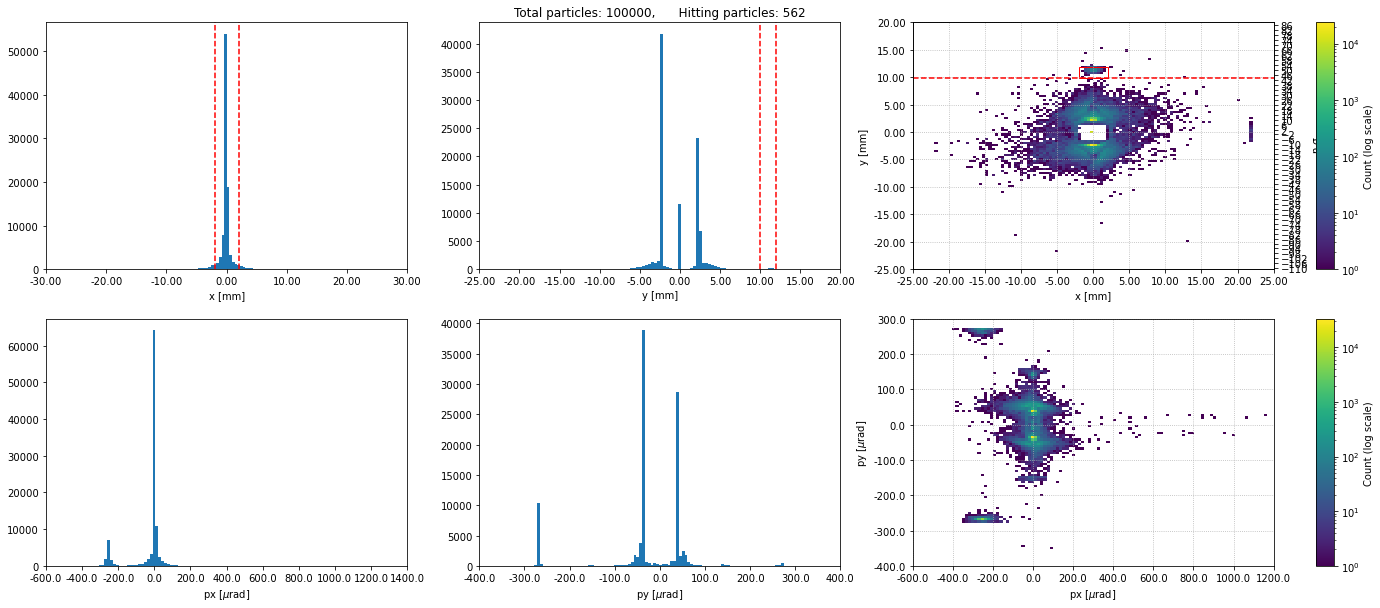

In [31]:
TARGET_IR3_IR7_7_2.compute_impact_particles(sigma=True)

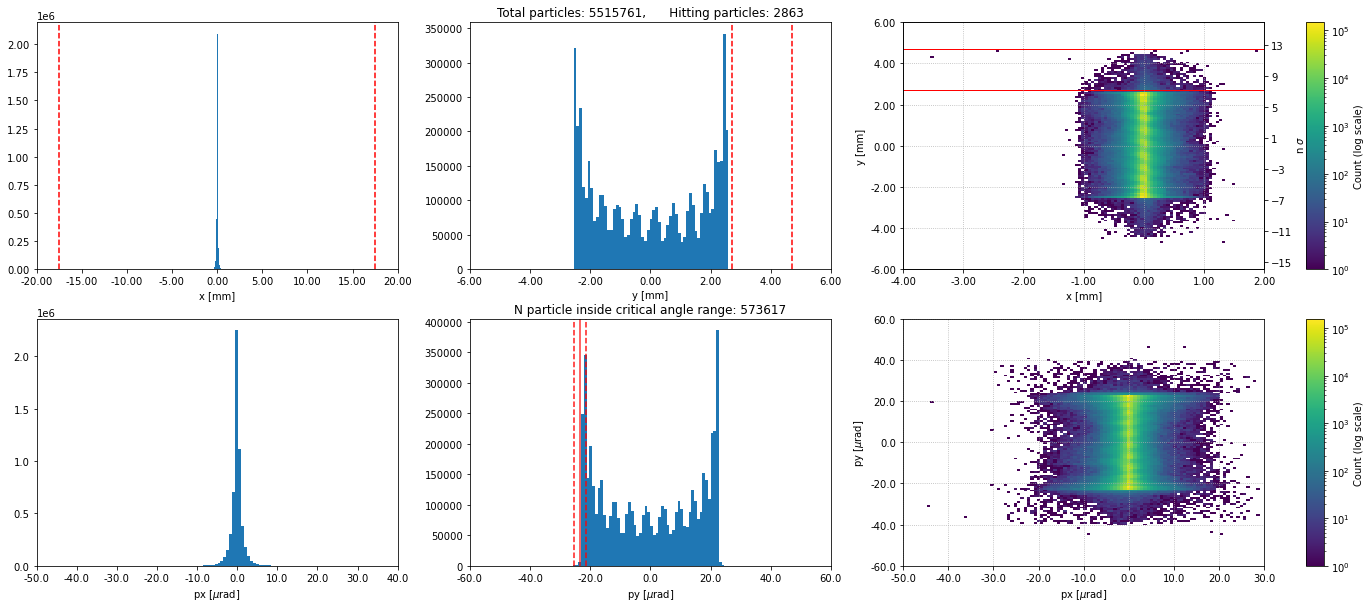

In [32]:
TCCS_IR3_IR7_7_2.compute_impact_particles(xpcrit=True)

In [33]:
TCCS_IR3_IR7_7_2.compute_channeled_part(TARGET_IR7_IR3_7_2.line_idx, TARGET_IR3_IR7_7_2.npart)

NameError: name 'TARGET_IR7_IR3_7_2' is not defined

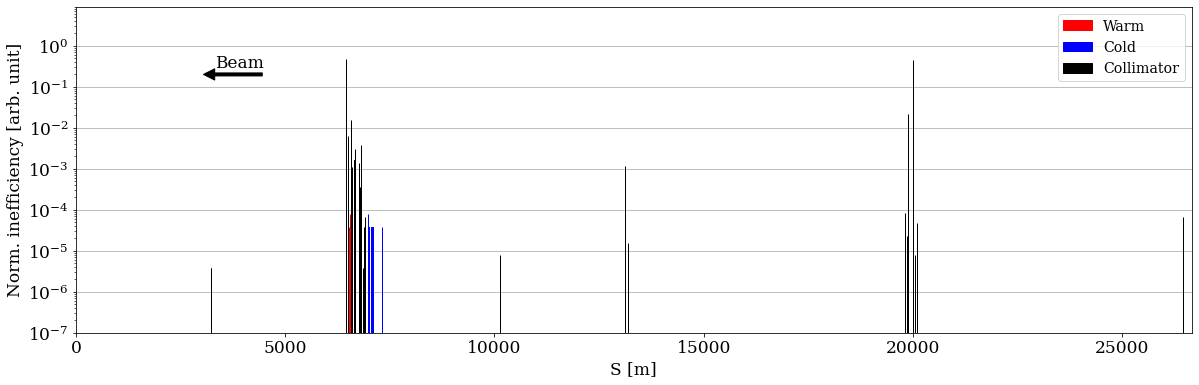

In [34]:
TARGET_IR3_IR7_7_2.load_lossmap(IR3_IR7rem_TCCS_7_2, zoom=False)

In [35]:
TARGET_IR3_IR7_7_2.compute_losses()

,s,name,losses_type,losses
2,6459.742798,tcp.d6r7.b2,Losses.COLL,119565.0
59,19885.183171,tccs.5r3.b2,Losses.COLL,5500.0
60,20005.545671,target.4l3.b2,Losses.COLL,114000.0
62,20084.662376,tcla.a5l3.b2,Losses.COLL,12.0


In [36]:
TCCS_IR7_7_2.load_particles(IR7rem_TCCS_7_2, df_key="TCCS_impacts")
TARGET_IR7_7_2.load_particles(IR7rem_TCCS_7_2, df_key="particles")

NameError: name 'TCCS_IR7_7_2' is not defined

In [37]:
TARGET_IR7_7_2.compute_impact_particles()

NameError: name 'TARGET_IR7_7_2' is not defined

In [38]:
TCCS_IR7_7_2.compute_impact_particles(xpcrit=True)

NameError: name 'TCCS_IR7_7_2' is not defined

In [39]:
test = 'TEST_IR7rem_TCCS_8.7__target_absorber_20240112-1058/Job.10/Outputdata/particles_B2V.h5'

In [40]:
a = ParticleAnalysis(element_type='target', n_sigma=34.6, length=0.005, ydim=0.002, xdim=0.004, jaw_L=0.0078058124348298966, line_idx=110984)
c = ParticleAnalysis(element_type='target', n_sigma=34.6, length=0.005, ydim=0.002, xdim=0.004, jaw_L=0.0078058124348298966, line_idx=110984)
b = ParticleAnalysis(element_type='crystal', n_sigma=8.7, length=0.004, ydim=0.002, xdim=0.035, bend=80.0, align_angle=-2.824183882125766e-05, jaw_L=0.00327920337391987, line_idx=110029)

In [41]:
c.load_particles(test, Condor=False, df_key='particles')

Error: File not found at /eos/home-i04/c/cmaccani/xsuite_sim/two_cryst_sim/Condor/TEST_IR7rem_TCCS_8.7__target_absorber_20240112-1058/Job.10/Outputdata/particles_B2V.h5


KeyError: 'particle_id'

In [42]:
a.load_particles(test, Condor=False, df_key='TARGET_impacts')

Error: File not found at /eos/home-i04/c/cmaccani/xsuite_sim/two_cryst_sim/Condor/TEST_IR7rem_TCCS_8.7__target_absorber_20240112-1058/Job.10/Outputdata/particles_B2V.h5


KeyError: 'particle_id'

In [95]:
b.load_particles(test, Condor=False, df_key='TCCS_impacts')  #df_key='TARGET_impacts'  df_key='TCCS_impacts'  df_key='particles'

In [96]:
a.data

,zeta,x,px,y,py,delta,gamma0,p0c,this_turn,particle_id,this_state,parent_particle_id,at_element,state,at_turn
0,5.616415e-04,-0.000508,5.785329e-06,0.011400,0.000140,-2.906018e-05,7460.522461,7.000000e+12,11,275,1,275,110984,-340,11
1,1.540438e-03,-0.000163,-3.531003e-06,0.011236,0.000137,-7.731108e-05,7460.522461,7.000000e+12,17,1051,1,1051,110984,-340,17
2,2.315342e-03,0.000421,-8.700760e-06,0.011753,0.000144,-8.429190e-05,7460.522461,7.000000e+12,39,1152,1,1152,110984,-340,39
3,4.711206e-04,-0.000516,6.789474e-06,0.011406,0.000140,-2.763233e-05,7460.522461,7.000000e+12,11,1195,1,1195,110984,-340,11
4,7.572795e-04,-0.001154,1.009422e-05,0.011345,0.000139,-5.082154e-05,7460.522461,7.000000e+12,11,1559,1,1559,110984,-340,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,7.554727e-03,-0.000551,8.632229e-06,0.012053,0.000148,-7.600349e-05,7460.522461,7.000000e+12,72,97858,1,97858,110984,-340,72
207,1.344413e-03,-0.000153,7.475111e-07,0.011035,0.000135,-6.784376e-05,7460.522461,7.000000e+12,28,97876,1,97876,110984,-340,28
208,-2.571596e-07,0.000367,-3.572485e-06,0.011467,0.000141,-8.254119e-07,7460.522461,7.000000e+12,0,98456,1,98456,110984,-340,0
209,3.888173e-03,0.000763,-4.460431e-06,0.011282,0.000138,-2.795737e-05,7460.522461,7.000000e+12,128,99758,1,99758,110984,-340,128


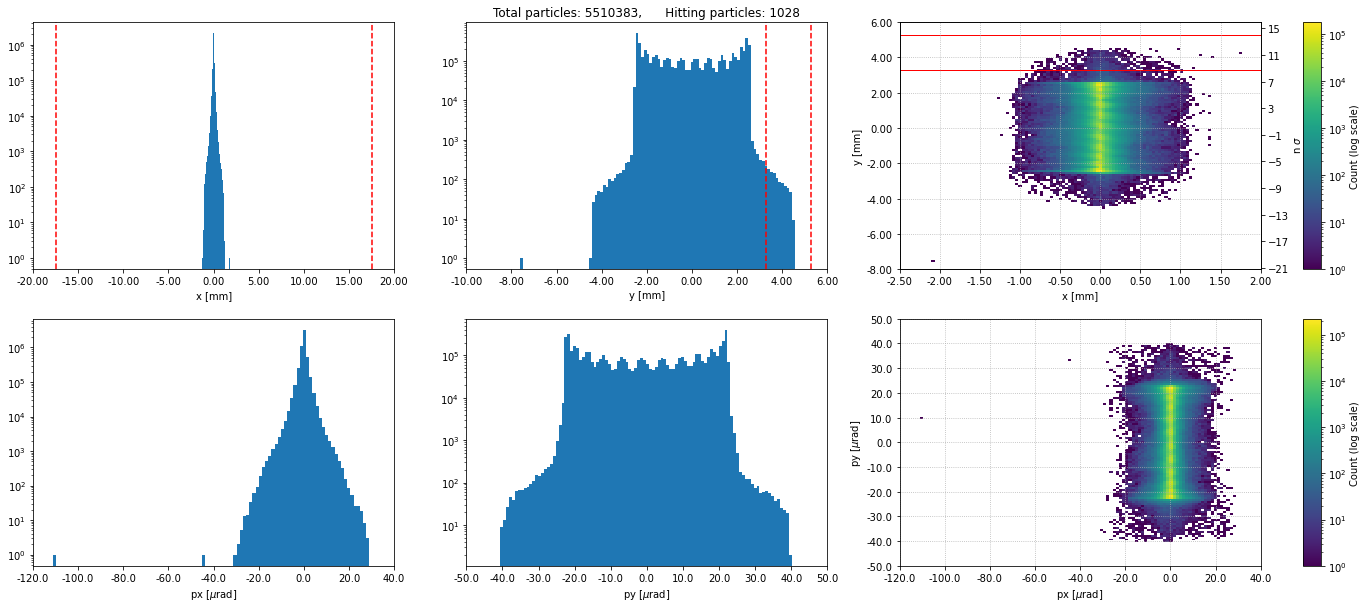

In [97]:
b.compute_impact_particles(log=True)

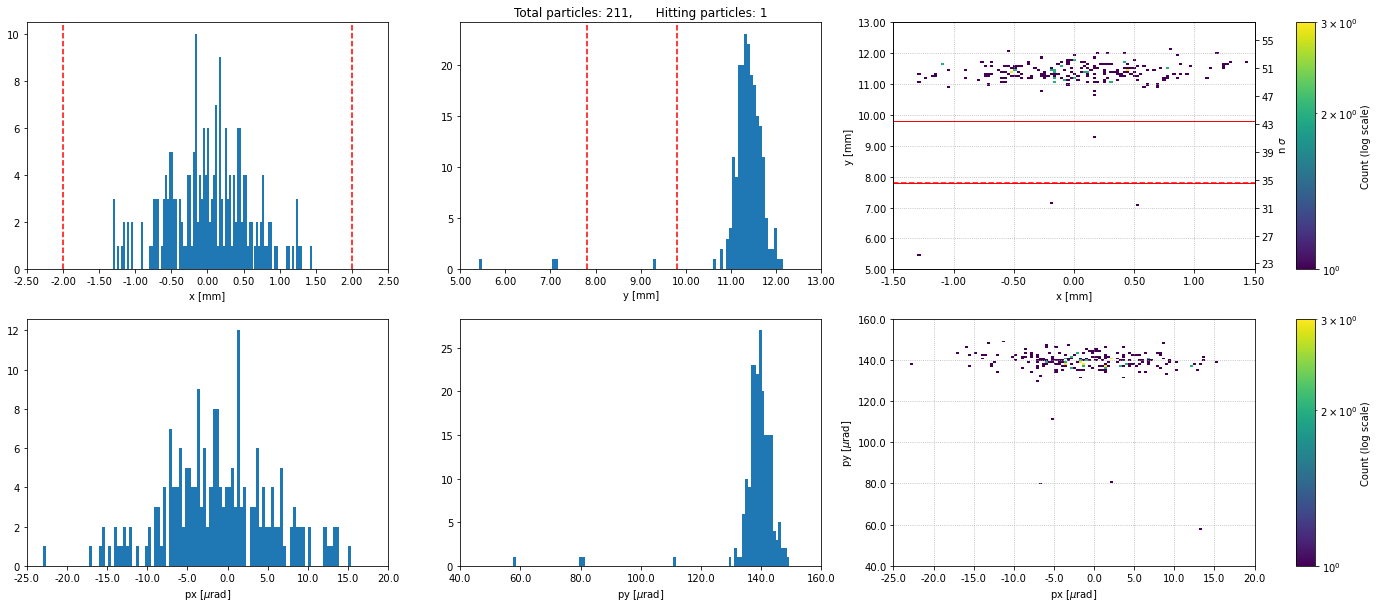

In [101]:
a.compute_impact_particles(sigma=True)

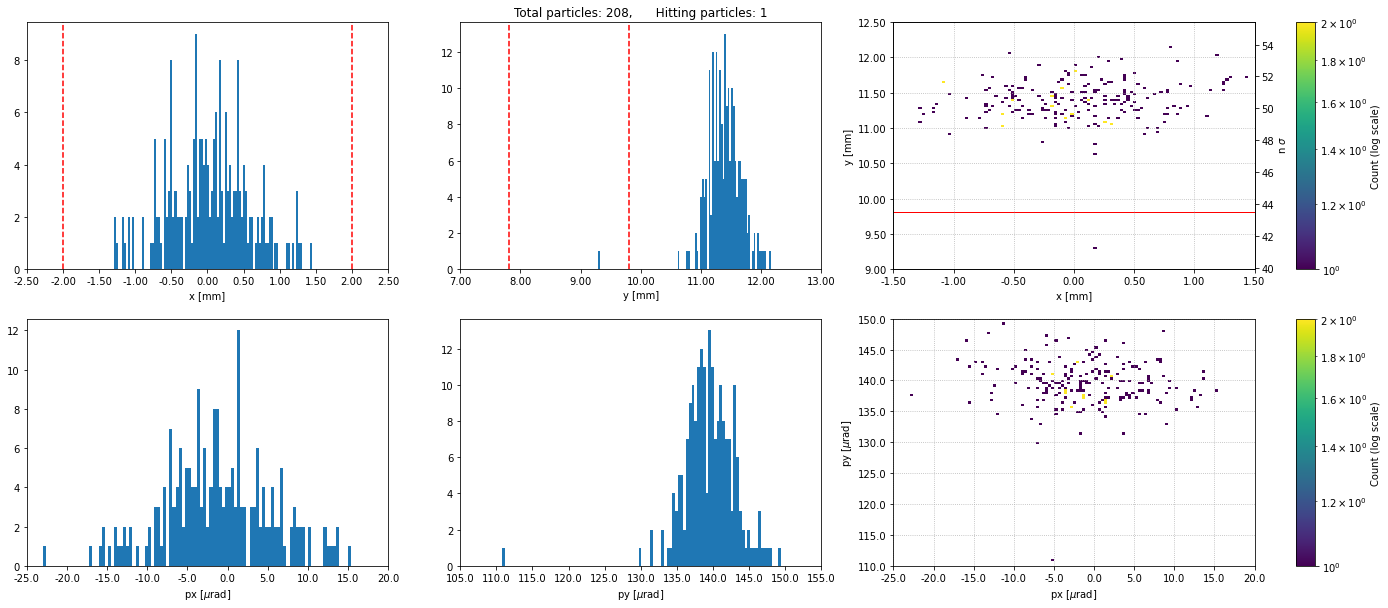

In [102]:
c.compute_impact_particles(Monitor=False, sigma=True)

In [87]:
a.data

,zeta,x,px,y,py,delta,gamma0,p0c,this_turn,particle_id,this_state,parent_particle_id,at_element,state,at_turn
0,5.616415e-04,-0.000508,5.785329e-06,0.011400,0.000140,-2.906018e-05,7460.522461,7.000000e+12,11,275,1,275,110984,-340,11
1,1.540438e-03,-0.000163,-3.531003e-06,0.011236,0.000137,-7.731108e-05,7460.522461,7.000000e+12,17,1051,1,1051,110984,-340,17
2,2.315342e-03,0.000421,-8.700760e-06,0.011753,0.000144,-8.429190e-05,7460.522461,7.000000e+12,39,1152,1,1152,110984,-340,39
3,4.711206e-04,-0.000516,6.789474e-06,0.011406,0.000140,-2.763233e-05,7460.522461,7.000000e+12,11,1195,1,1195,110984,-340,11
4,7.572795e-04,-0.001154,1.009422e-05,0.011345,0.000139,-5.082154e-05,7460.522461,7.000000e+12,11,1559,1,1559,110984,-340,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
206,7.554727e-03,-0.000551,8.632229e-06,0.012053,0.000148,-7.600349e-05,7460.522461,7.000000e+12,72,97858,1,97858,110984,-340,72
207,1.344413e-03,-0.000153,7.475111e-07,0.011035,0.000135,-6.784376e-05,7460.522461,7.000000e+12,28,97876,1,97876,110984,-340,28
208,-2.571596e-07,0.000367,-3.572485e-06,0.011467,0.000141,-8.254119e-07,7460.522461,7.000000e+12,0,98456,1,98456,110984,-340,0
209,3.888173e-03,0.000763,-4.460431e-06,0.011282,0.000138,-2.795737e-05,7460.522461,7.000000e+12,128,99758,1,99758,110984,-340,128


In [89]:
c.impact_part

,zeta,particle_id,at_element,at_turn,state,parent_particle_id,x,y,px,py,delta,p0c,gamma0
12068,5.783026e-03,9049,110984,167,-340,9049,-0.000427,0.011313,9.470607e-06,0.000139,-6.627799e-05,7.000000e+12,7460.522461
12529,7.652988e-03,64734,110984,153,-340,64734,-0.000170,0.011309,-2.238705e-06,0.000138,-3.042644e-05,7.000000e+12,7460.522461
12761,1.200062e-02,79001,110984,150,-340,79001,-0.000727,0.011559,1.354981e-05,0.000142,-2.436343e-05,7.000000e+12,7460.522461
13028,4.637856e-03,96732,110984,144,-340,96732,-0.000583,0.011041,1.026951e-05,0.000135,-6.484790e-05,7.000000e+12,7460.522461
13029,6.441540e-03,70561,110984,144,-340,70561,-0.000682,0.011318,1.540659e-05,0.000139,-7.616936e-05,7.000000e+12,7460.522461
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95785,1.950214e-05,92882,110984,0,-340,92882,-0.001174,0.011280,1.243566e-05,0.000138,-1.508791e-06,7.000000e+12,7460.522461
95786,5.523880e-06,62826,110984,0,-340,62826,0.000033,0.011143,-8.525616e-08,0.000136,-1.328200e-06,7.000000e+12,7460.522461
95787,1.173855e-05,61397,110984,0,-340,61397,-0.000351,0.011207,3.843727e-06,0.000137,-1.820698e-06,7.000000e+12,7460.522461
95788,2.443732e-05,58780,110984,0,-340,58780,-0.001158,0.011238,1.225079e-05,0.000137,-2.613694e-06,7.000000e+12,7460.522461


# NEW TRIALS

In [161]:
test_29_TCCS = ParticleAnalysis(element_type='crystal', n_sigma=8.7, length=0.004, ydim=0.002, xdim=0.035, bend=80.0, align_angle=-2.824183882125766e-05, jaw_L=0.00327920337391987, line_idx=110029)
test_29_TCCS.load_particles('TEST_IR7rem_TCCS_8.7__target_absorber_20240112-1529', Condor=True, df_key='TCCS_impacts')

0    npart:  0
TURN:  0 
 0.000600434432271868 11 


1028  particles loaded from  0    total particles:  1028
1    npart:  1028
1011  particles loaded from  1    total particles:  2039
2    npart:  2039
1095  particles loaded from  2    total particles:  3134
3    npart:  3134
1121  particles loaded from  3    total particles:  4255
4    npart:  4255
1060  particles loaded from  4    total particles:  5315
5    npart:  5315
1035  particles loaded from  5    total particles:  6350
6    npart:  6350
1107  particles loaded from  6    total particles:  7457
7    npart:  7457
1094  particles loaded from  7    total particles:  8551
8    npart:  8551
1009  particles loaded from  8    total particles:  9560
9    npart:  9560
1089  particles loaded from  9    total particles:  10649
10    npart:  10649
1064  particles loaded from  10    total particles:  11713
11    npart:  11713
1022  particles loaded from  11    total particles:  12735
12    npart:  12735
1069  particles loaded from  12    t

In [163]:
test_29_TARGET=ParticleAnalysis(element_type='target', n_sigma=34.6, length=0.005, ydim=0.002, xdim=0.004, jaw_L=0.0078058124348298966, line_idx=110984)
test_29_TARGET.load_particles('TEST_IR7rem_TCCS_8.7__target_absorber_20240112-1529', Condor=True, df_key='TARGET_impacts')

0    npart:  0
TURN:  0 
 0.0006000114372000098 11 


219  particles loaded from  0    total particles:  219
1    npart:  219
181  particles loaded from  1    total particles:  400
2    npart:  400
248  particles loaded from  2    total particles:  648
3    npart:  648
229  particles loaded from  3    total particles:  877
4    npart:  877
189  particles loaded from  4    total particles:  1066
5    npart:  1066
223  particles loaded from  5    total particles:  1289
6    npart:  1289
238  particles loaded from  6    total particles:  1527
7    npart:  1527
209  particles loaded from  7    total particles:  1736
8    npart:  1736
207  particles loaded from  8    total particles:  1943
9    npart:  1943
214  particles loaded from  9    total particles:  2157
10    npart:  2157
202  particles loaded from  10    total particles:  2359
11    npart:  2359
213  particles loaded from  11    total particles:  2572
12    npart:  2572
214  particles loaded from  12    total particles:  2786
13  

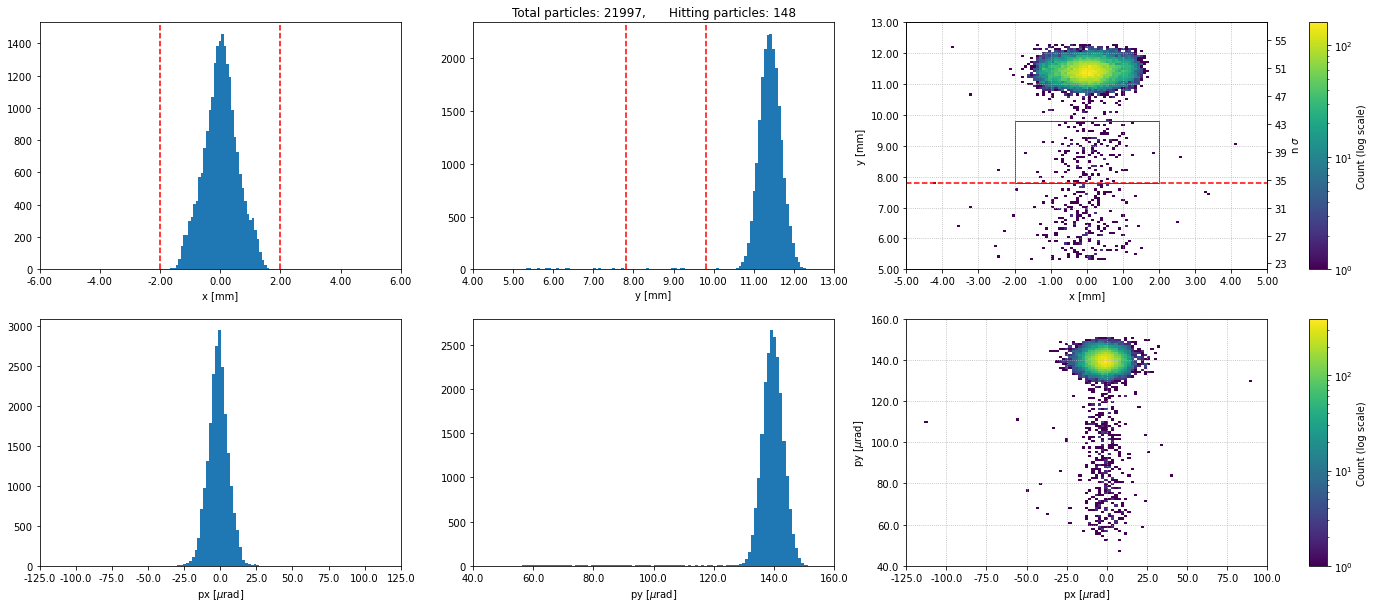

In [164]:
test_29_TARGET.compute_impact_particles(sigma=True)

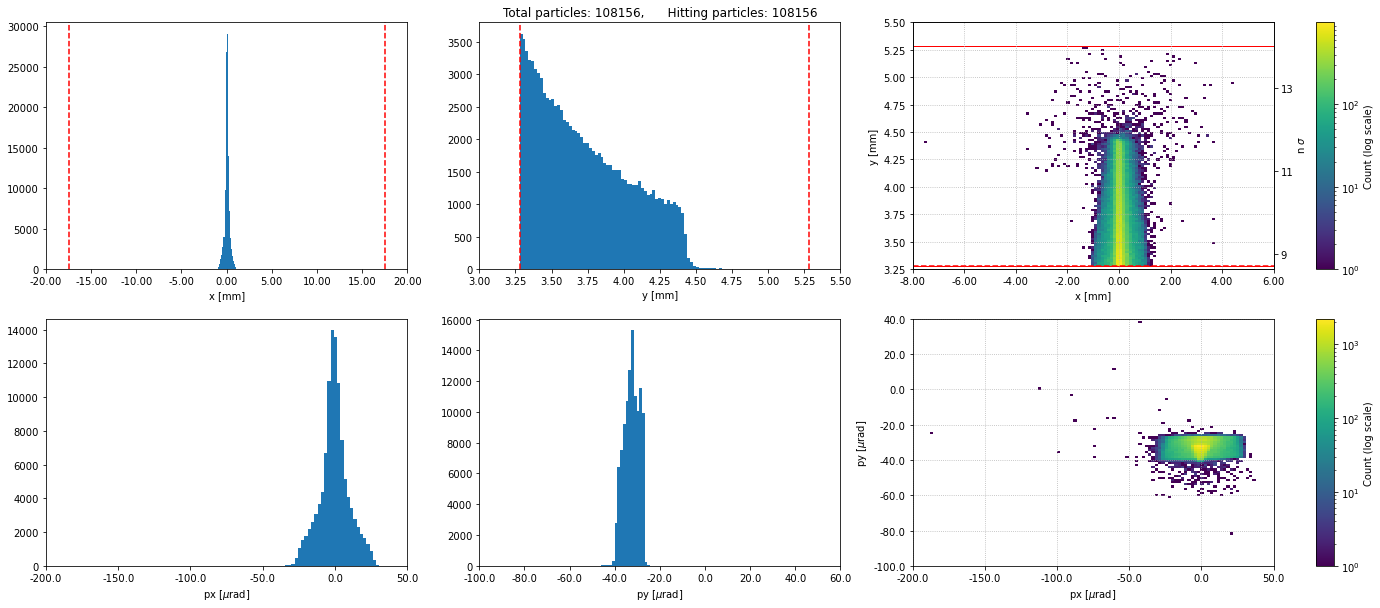

In [165]:
test_29_TCCS.compute_impact_particles(sigma=True)

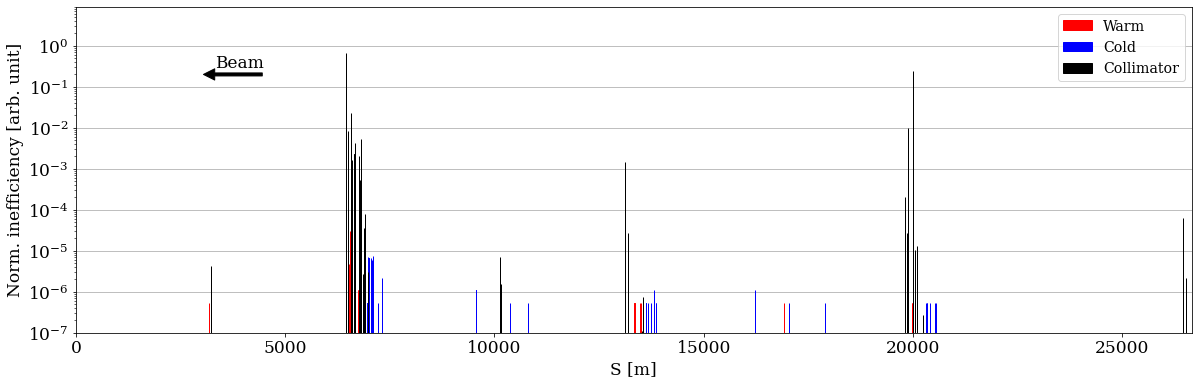

In [100]:
test_29_TCCS.load_lossmap('TEST_IR7rem_TCCS_8.7__target_absorber_20240112-1529', Condor=True, zoom=False)

In [101]:
df = test_29_TCCS.compute_losses()
df

,s,name,losses_type,losses,length,npart
4,6459.742798,tcp.d6r7.b2,Losses.COLL,1.199700e+07,0.600,7198198.0
1054,19885.183171,tccs.5r3.b2,Losses.COLL,1.840000e+05,0.004,736.0
1057,20005.545671,target.4l3.b2,Losses.COLL,4.360800e+06,0.005,21804.0
1061,20084.662376,tcla.a5l3.b2,Losses.COLL,2.420000e+02,1.000,242.0
